<a href="https://colab.research.google.com/github/juliakreutzer/yocco/blob/master/Garbage_Detection_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [34]:
import tensorflow as tf
tf.__version__
import keras
keras.__version__

'2.2.5'

# DOWNLOAD AND EXTRACT IMAGES

In [0]:
import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns
import random

In [4]:
files = zf.ZipFile("/content/drive/My Drive/Colab Notebooks/Climate Change Hackathon/dataset-resized.zip",'r')
files.extractall()
files.close()
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['paper', 'metal', 'trash', 'plastic', 'cardboard', '.DS_Store', 'glass']

In [0]:
## helper functions ##

## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.7*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [0]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid', 'test']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)

In [0]:
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    test_dest = "data/test/"+waste_type
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files, test_dest)

# MODEL

In [8]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.layers import Dropout
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input
from keras.optimizers import Adam
from sklearn.metrics import  classification_report

Using TensorFlow backend.


In [9]:
base_model=MobileNet(weights='imagenet',include_top=False,
                     input_shape=(224, 224, 3)) #imports the mobilenet model and discards the last 1000 neuron layer.







17227776/17225924 [==============================] - 3s 0us/step


In [10]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [11]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dropout(0.5)(x)
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dropout(0.5)(x)
x=Dense(512,activation='relu')(x) #dense layer 3
x=Dropout(0.2)(x)
preds=Dense(6,activation='softmax')(x) #final layer with softmax activation
model=Model(inputs=base_model.input,outputs=preds)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
len(model.layers)

95

In [0]:
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [14]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [0]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   fill_mode='nearest',
                                   horizontal_flip=True,
                                   shear_range=0.2,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2) # Your Code Here

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [16]:
from imutils import paths
train_dir = 'data/train'
validation_dir = 'data/valid/'
test_dir = 'data/test/'
totalTrain = len(list(paths.list_images(train_dir)))
totalVal = len(list(paths.list_images(validation_dir)))
totalTest = len(list(paths.list_images(test_dir)))
print("Total Training: ", totalTrain)
print("Total Validation: ",totalVal)
print("Total test: ", totalTest)

Total Training:  1766
Total Validation:  378
Total test:  383


In [0]:
BATCH_SIZE = 16
TARGET_SIZE = (224, 224)

In [18]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                    color_mode='rgb',
                                                    shuffle=True,
                                                   target_size=TARGET_SIZE)     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                   batch_size=BATCH_SIZE,
                                                   color_mode='rgb',
                                                   class_mode='categorical',
                                                   shuffle=False,
                                                   target_size=TARGET_SIZE)

# initilaize the testing generator
test_generator = test_datagen.flow_from_directory(
    test_dir, 
    class_mode="categorical",
    color_mode='rgb',
    target_size=TARGET_SIZE,  
    shuffle=False, 
    batch_size=BATCH_SIZE)

Found 1766 images belonging to 6 classes.
Found 378 images belonging to 6 classes.
Found 383 images belonging to 6 classes.


In [19]:
print("[INFO] compiling model...")
opt = Adam(lr=1e-5)
model.compile(loss='categorical_crossentropy', optimizer=opt,
             metrics=['accuracy'])

[INFO] compiling model...



In [20]:
# train the head of the network for a few epochs (all other layers
# are frozen) -- this willl allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("[INFO] trainning head...")
H = model.fit_generator( 
    train_generator,
    steps_per_epoch=totalTrain // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=totalVal // BATCH_SIZE,
    epochs=50)

[INFO] trainning head...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
110/110 [==============================] - 32s 289ms/step - loss: 1.9677 - acc: 0.2112 - val_loss: 1.6078 - val_acc: 0.3533
Epoch 2/50
110/110 [==============================] - 25s 228ms/step - loss: 1.8455 - acc: 0.2485 - val_loss: 1.4538 - val_acc: 0.4862
Epoch 3/50
110/110 [==============================] - 25s 225ms/step - loss: 1.7044 - acc: 0.3174 - val_loss: 1.3577 - val_acc: 0.5470
Epoch 4/50
110/110 [==============================] - 25s 225ms/step - loss: 1.5612 - acc: 0.3720 - val_loss: 1.2430 - val_acc: 0.5939
Epoch 5/50
110/110 [==============================] - 24s 222ms/step - loss: 1.4581 - acc: 0.4170 - val_loss: 1.1572 - val_acc: 0.6298
Epoch 6/50
110/110 [==============================] - 24s 219ms/step - loss: 1.3517 - acc: 0.4684 - val_loss: 1.0702 - val_acc: 0.6354
Epoch 7/50
110/110 [==============================] - 24s 219ms/step - 

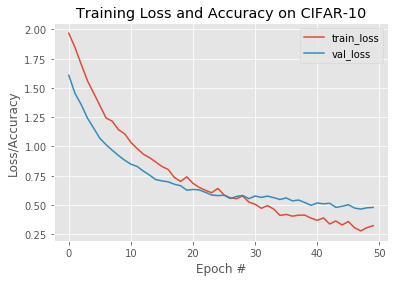

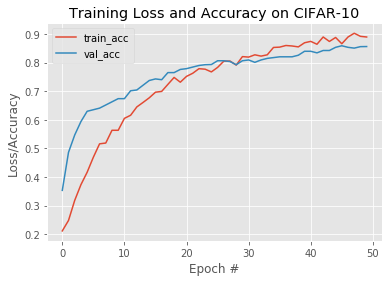

In [21]:
import matplotlib.pyplot as plt
# plot the training loss and accuracy
N = np.arange(0, 50)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy on CIFAR-10")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.figure()
plt.plot(N, H.history["acc"], label="train_acc")
plt.plot(N, H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on CIFAR-10")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [22]:
# reset the testing generator and evaluate the network after
# fine-tuning just the network head
print("[INFO] evaluating after fine-tuning network head...")
test_generator.reset()
predIdxs = model.predict_generator(test_generator, 
     steps=(totalTest // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(test_generator.classes, predIdxs, 
     target_names=test_generator.class_indices.keys()))
# plot_training(H, 50, config.WARMUP_PLOT_PATH)

[INFO] evaluating after fine-tuning network head...
              precision    recall  f1-score   support

   cardboard       1.00      0.87      0.93        61
       glass       0.85      0.91      0.88        76
       metal       0.88      0.92      0.90        62
       paper       0.91      0.91      0.91        90
     plastic       0.93      0.86      0.89        73
       trash       0.65      0.81      0.72        21

    accuracy                           0.89       383
   macro avg       0.87      0.88      0.87       383
weighted avg       0.90      0.89      0.89       383



In [23]:
# serialize the model to disk
print("[INFO] serializing network...")
model.save('hack_mobilenet.h5')

[INFO] serializing network...


In [0]:
# import the necessary packages
from keras.models import load_model
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
%matplotlib inline

In [25]:
# load the trained model from disk
print("[INFO] loading model...")
model = load_model('hack_mobilenet.h5')

[INFO] loading model...


In [0]:
from keras.applications.mobilenet import decode_predictions, preprocess_input
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import imutils
import cv2
%matplotlib inline

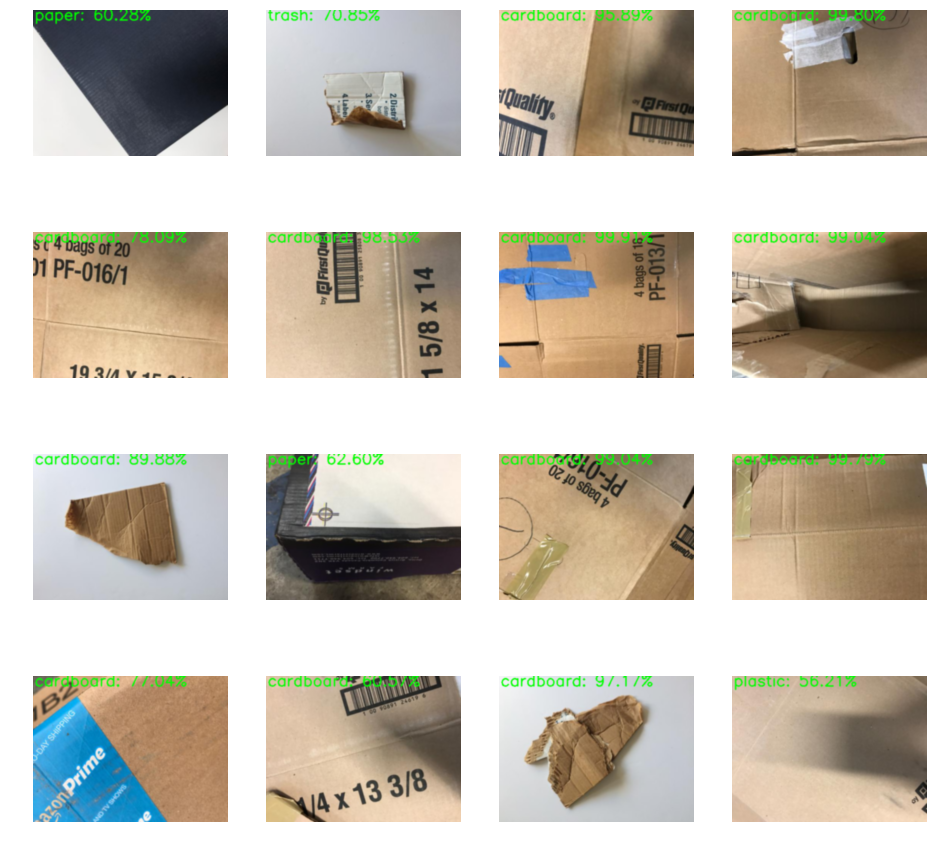

In [28]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 8
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

# pic_index += 8

# load the input image and then clone it so we can draw on it later
waste_types = ['cardboard','glass','metal','paper','plastic','trash']
test_d = 'data/test/' + waste_types[0] + '/'
# test_d = 'mytest/'
test_files = os.listdir(test_d)[0:16]
for i, fn in enumerate(test_files):
    
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1, facecolor='red')
    sp.axis('Off') # Don't show axes (or gridlines)
    # predicting images
    path = test_d + fn
    image = cv2.imread(path)

    img = load_img(path, target_size=TARGET_SIZE)

    output = image.copy()
    output = imutils.resize(output, width=400)

    img = img_to_array(img)
    
    # our model was trained on RGB ordered images but OpenCV represents
    # images in BGR order, so swap the channels, and then resize to
    # 224x224 (the input dimensions for VGG16)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, TARGET_SIZE)
    # print(image.shape)
    
    # convert the image to a floating point data type and perform mean
    # subtraction
    image = image.astype("float32") / 255.
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)

    # pass the image through the network to obtain our predictions
    # preds = model.predict(np.expand_dims(image / 255., axis=0))[0]
    preds = model.predict(img)[0]
    i = np.argmax(preds)
    label = waste_types[i]
    # print(label)
    
    # draw the prediction on the output image
    text = "{}: {:.2f}%".format(label, preds[i] * 100)
    cv2.putText(output, text, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 1.05,
        (0, 255, 0), 2)
    
    # show the output image
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB), interpolation = 'bicubic')
    # cv2.imshow("Output", output)
    # cv2.waitKey(0)
plt.show()

In [0]:
!cp hack_mobilenet.h5 '/content/drive/My Drive/Colab Notebooks/Climate Change Hackathon/'